In [1]:
import numpy as np
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [5]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

# Load Dataset - Imagenet2012 validation set 50000 images

In [8]:
def preprocess_image(features):
    """Preprocesses the given image.

      Args:
        image: `Tensor` representing an image of arbitrary size.

      Returns:
        A preprocessed image `Tensor` of range [0, 1].
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    
    features["image"] = image
    return features

In [18]:
BATCH_SIZE = 50
tfds_dataset2, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/')

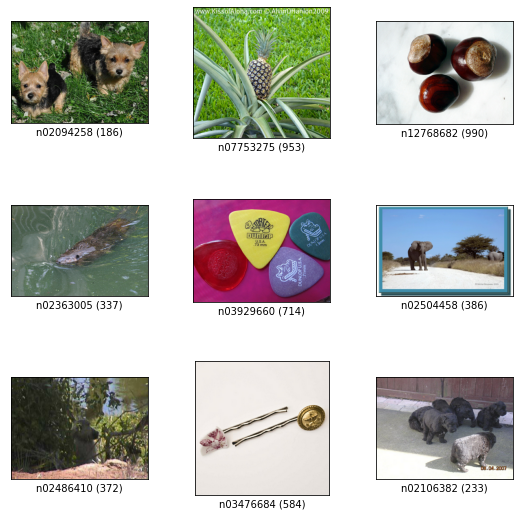

In [46]:
figs = tfds.show_examples(tfds_dataset2, tfds_info)

In [20]:
val_ds = tfds_dataset2.map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

In [47]:
def extract(ith_image, ds):
    for i, features in enumerate(ds):
        if ith_image < 50 and i == 0:
            image = np.expand_dims(features["image"].numpy()[ith_image], axis=0)
            label = features["label"].numpy()[ith_image]
            break
        
        elif i == np.floor(ith_image/50):
            image = np.expand_dims(features["image"].numpy()[ith_image%50], axis=0)
            label = features["label"].numpy()[ith_image%50]
            break
    return image, label

In [48]:
image,label = extract(0,val_ds)

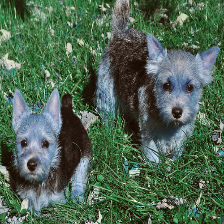

In [49]:
pil_img = tf.keras.preprocessing.image.array_to_img(image[0,:,:,:])
from IPython.display import Image
display(pil_img)

In [6]:
interpreter_quant = tf.lite.Interpreter("./tflite_int8_model_40.tflite")
interpreter_quant.allocate_tensors()

In [7]:
'''
Check input/output details
'''
input_details = interpreter_quant.get_input_details()
output_details = interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: input_4
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [   1 1000]
type: <class 'numpy.float32'>


In [8]:
'''
This gives a list of dictionaries. 
'''
tensor_details = interpreter_quant.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization_parameters']['scales']
    zero_points = dict['quantization_parameters']['zero_points']
    tensor = interpreter_quant.tensor(i)()

    print(i, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(tensor)

0 input_4 (0,) (0,) (1, 224, 224, 3)
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]
1 resnet50/quant_avg_pool/Mean/reduction_indices (0,) (0,) (2,)
[1 2]
2 resnet50/quant_conv1_pad/Pad/paddings (0,) (0,) (4, 2)
[[0 0]
 [3 3]
 [3 3]
 [0 0]]
3 resnet50/quant_pool1_pad/Pad/paddings (0,) (0,) (4, 2)
[[0 0]
 [1 1]
 [1 1]
 [0 0]]
4 resnet50/quant_predictions/BiasAdd/ReadVariableOp/resource (1,) (1,) (1000,)
[ -60  -36  -52  -89  -16  -79  -23  -21  -47  -50  -59  -42  -84  -38
  -34

In [9]:
interpreter_quant_ft16 = tf.lite.Interpreter("./tflite_ft16_model_40.tflite")
interpreter_quant_ft16.allocate_tensors()
'''
This gives a list of dictionaries. 
'''
tensor_details = interpreter_quant_ft16.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization_parameters']['scales']
    zero_points = dict['quantization_parameters']['zero_points']
    tensor = interpreter_quant_ft16.tensor(i)()

    print(i, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(tensor)

RuntimeError: tensorflow/lite/kernels/quantize.cc:111 affine_quantization->scale->size == 1 was not true.Node number 1 (QUANTIZE) failed to prepare.


In [ ]:
tf.quantization.dequantize(
    input, min_range, max_range, mode='MIN_COMBINED', name=None,
    axis=None, narrow_range=False, dtype=tf.dtypes.float32
)

In [7]:
interpreter_quant = tf.lite.Interpreter("./tflite_int8_model_40.tflite")
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter_quant.resize_tensor_input(input_index, [BATCH_SIZE, 224, 224, 3])
interpreter_quant.resize_tensor_input(output_index, [1000])
interpreter_quant.allocate_tensors()

In [ ]:
interpreter.set_tensor(input_index, image)
interpreter.invoke()
logits = interpreter.tensor(output_index)